# Prediction indoor / outdoor using CLIP

In [ ]:
import clip
from fastai.vision.all import *

import glob
import pandas as pd
import PIL
import newlinejson

In [17]:
def clip_predict(text_features, labels, img_path, k=2):
    '''
    function to predict indoor/outdoor using CLIP
    '''
    output_ = {}
    image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
    
    with torch.no_grad():
        image_features = model.encode_image(image)
    
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(k)
    
    for i, _ in enumerate(values):
        output_[labels[i]] = np.round(values[i].item(), 2)

    return output_

In [18]:
input_path = '../data/raw/test'

## Make Prediction with CLIP

In [19]:
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

In [20]:
# getting files
files = get_image_files(input_path)
files[0]

Path('../data/raw/test/NL-HlmNHA_1478_00032K00_14.jpg')

In [21]:
new_labels = ['a photograph taken indoors', 'a photograph taken outdoors']
dutch_labels = ['binnen', 'buiten']

text = clip.tokenize(new_labels).to(device)
with torch.no_grad():
    text_features = model.encode_text(text)

## Previewing Image

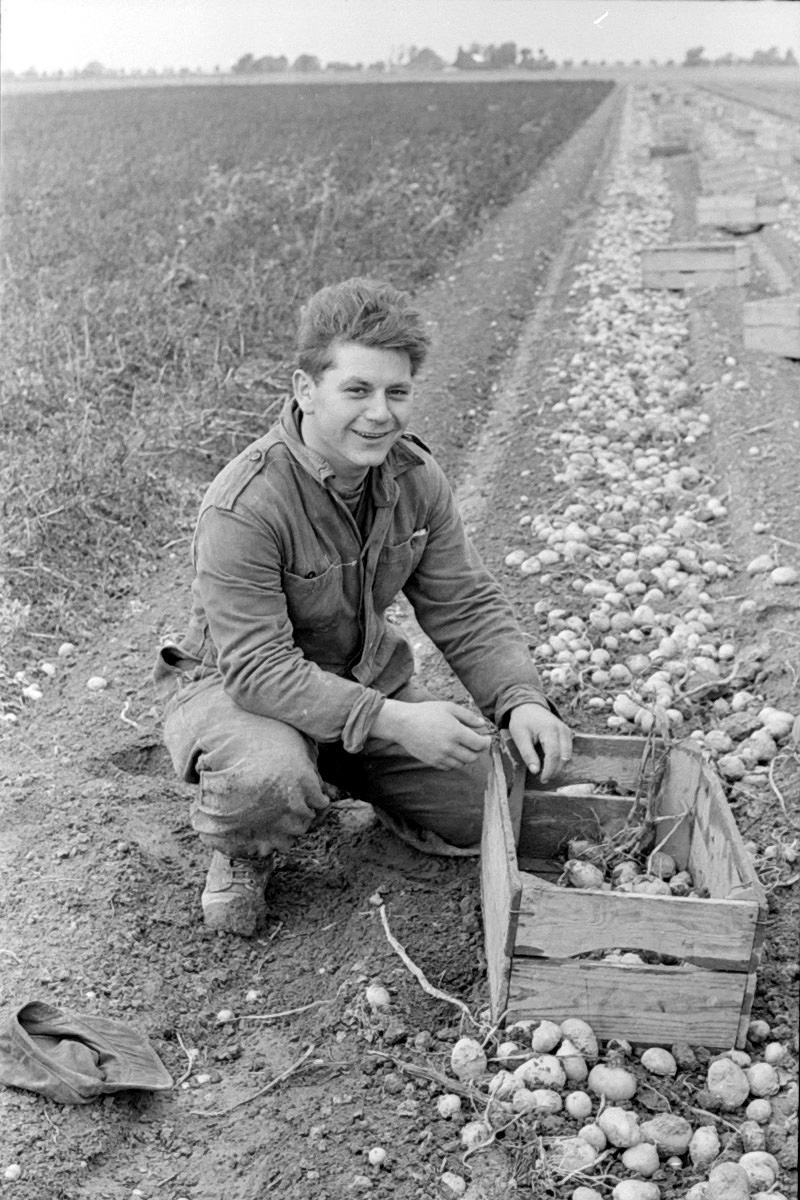

In [22]:
PIL.Image.open(files[0]).convert('RGB')

In [23]:
output = clip_predict(text_features, dutch_labels, files[0])
print(output)

{'binnen': 0.99, 'buiten': 0.01}


# Make predictions for folder of images

In [47]:
imgs = glob.glob('../../sample_images/HisVis2/**/*.jpg') #folder with images 
df = pd.read_csv('../data/intermediary/indoor_outdoor_sample_images.csv') #metadata

In [ ]:
results = list()
counter = 1

text = clip.tokenize(new_labels).to(device)
with torch.no_grad():
    text_features = model.encode_text(text)

for img in imgs:
    if counter % 100 == 0:
        print(counter)
    serial_number = int(np.floor(counter/500)) + 1
    series = f'random_{serial_number}_binnenbuiten'
    d = dict()
    filename = os.path.basename(img)[:-4]
    d['uuid'] = df[df['file_name'] == filename]['uuid'].values[0]
    d['filename'] = filename
    d['series'] = series
    d['predictions'] = clip_predict(text_features, img);
    
    results.append(d)
    counter += 1

In [ ]:
#export predictions

with open('./resultsRandomBatch10_binnenbuiten.json', "w") as f:
        newlinejson.dump(results, f)